# 4 - Influential Classification Models (and Tools)

## Introduction

This Notebook (5) will continue on from the previous sections. This notebook will go through the process of using __Getting Models from TensorFlow Hub__. Previously, the notebook focused on implementing the ResNet model from Keras Applications, here, the intention is to utilise the models that were curated from Tensorflow Hub and specifically using the Inception V3 Model.

## Supporting Utilities .py files:

In this Notebook, there will be a requirement to import the code/utilities from the following files (.py files):
- DataPrepCIFAR_utility.py
- customCallbacks_Keras.py
-

## Dataset:

For this part of the project, the CIFAR-100 dataset will be used, it is a collection of of 60,000 32x32 images that have 100 classes. CIFAR-100 was originally collected by Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton. It iss also a subset of the 80 million tiny images dataset. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses.

Source: https://www.cs.toronto.edu/~kriz/cifar.html

Further, the TensorFlow team offers a python package called "tensorflow_datasets" that provides the helper function to download tthis dataset as well as other more common ones. For the purposes of this project, the CIFAR-100 dataset will be download with this package.

Source: https://www.tensorflow.org/datasets/catalog/cifar100

## Requirements:
- Tensorflow 2.0 (GPU is better)
- Tensorflow-Hub
- Keras (GPU is better)

### Import the required libraries:

In [1]:
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import math
import timeit

In [2]:
import os
# from IPython.display import display, Image
# import matplotlib.pyplot as plt

# %matplotlib inline

# Set up the working directory for the images:
image_folderName = 'Description Images'
image_path = os.path.abspath(image_folderName) + '/'

In [3]:
# Set the random set seed number: for reproducibility.
Seed_nb = 42

### GPU Information:

In [4]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))
devices = sess.list_devices()
devices

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2070 SUPER, pci bus id: 0000:09:00.0, compute capability: 7.5



[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456, 8120490652647963641),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 6586313605, 1993847600325718994)]

## 1 - Hyperparameters:

In [5]:
# input_shape = [224, 224, 3]

# Define the Expected input and output shape for the model:
inception_expected_inputShape = [299, 299, 3]
inception_expected_outputShape = [2048]

batch_size = 64
nb_epochs = 300

## 2 - Data Preparation and Defining the Input Pipeline:

To use the TensorFlow package, please ensure to install it: "pip install tensorflow-datasets" or use the Anaconda Navigator.

## 2.1 - Download the Dataset:

In [6]:
import tensorflow_datasets as tfds
import DataPrepCIFAR_utility

In [7]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

In [8]:
# Get the Dataset Information:
cifarData_info = DataPrepCIFAR_utility.get_info()
print(cifarData_info)

tfds.core.DatasetInfo(
    name='cifar100',
    version=1.3.1,
    description='This dataset is just like the CIFAR-10, except it has 100 classes containing 600 images each. There are 500 training images and 100 testing images per class. The 100 classes in the CIFAR-100 are grouped into 20 superclasses. Each image comes with a "fine" label (the class to which it belongs) and a "coarse" label (the superclass to which it belongs).',
    urls=['https://www.cs.toronto.edu/~kriz/cifar.html'],
    features=FeaturesDict({
        'coarse_label': ClassLabel(shape=(), dtype=tf.int64, num_classes=20),
        'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=100),
    }),
    total_num_examples=60000,
    splits={
        'test': 10000,
        'train': 50000,
    },
    supervised_keys=('image', 'label'),
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {Learning multi

## 2.2 - Set up the dataset:

In [9]:
# Set the number of classes:
nb_classes = cifarData_info.features['label'].num_classes

# Define the number of images for training and validation:
nb_train_imgs = cifarData_info.splits['train'].num_examples
nb_valid_imgs = cifarData_info.splits['test'].num_examples

## 2.3 - Set the "steps_per_epoch" for Training and Validation Set:

From the previous code block, the dataset is compatible with Keras methods liike "model.fit()", but will also require the "steps_per_epoch" to be specified. This is the number of batches per epoch of the Dataset objects that has to be specified for the Keras method so that it can work properly together. This is done for the training batches ("steps_per_epoch") and validation batches ("validation_steps").

In [10]:
train_steps_per_epoch = math.ceil(nb_train_imgs / batch_size)

valid_steps_per_epoch = math.ceil(nb_valid_imgs / batch_size)

## 2.4 - Load in the Dataset:

In [11]:
# Training Dataset:
train_set_cifar = DataPrepCIFAR_utility.get_dataset(phase='train',
                                                    batch_size= batch_size,
                                                    nb_epochs= nb_epochs,
                                                    shuffle=True,
                                                    input_shape= inception_expected_inputShape,
                                                    seed= Seed_nb)

# Validation Dataset:
val_set_cifar = DataPrepCIFAR_utility.get_dataset(phase='test',
                                                  batch_size= batch_size,
                                                  nb_epochs= 1,
                                                  shuffle= False,
                                                  input_shape= inception_expected_inputShape,
                                                  seed= Seed_nb)

Now that the CIFAR-100 dataset has been prepared. The next stage is to call the ResNet model.

## 3 - Grab the Inception Model from Tensorflow Hub:

This section will focus on building a classification model with Inception by Google that is fetched from TensorFlow Hub. TensorFlow Hub is similar to Keras Applications, where it is a repository of pretrained models, it makes it easier to users to spend less time and resources with the model's reimplementation or training. It utilises the website link "http://tfhub.dev" to search for the required/specified model and downloads it via the Python Package.

## 3.1 - Build the Inception Classifier:

To do this:
1) Search for the model on "http://tfhub.dev" \
2) The Inception model's link is: https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4 \
    - Note: It is called a Feature Vector because the final dense layers were removed from it. \
3) Save the link above as a variable to be passed into the "KerasLayer".

In [12]:
# TF2.0 Compatible Inception Model:
module_url = "https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4"

### Fetch the model:

Grab the model and its pre-trained weights from TensorFlow Hub in order to instantiate the model as a Keras Layer.

In [13]:
hub_feature_extractor = hub.KerasLayer(handle = module_url,
                                       trainable = False,
                                       input_shape = inception_expected_inputShape,
                                       output_shape = inception_expected_outputShape,
                                       dtype = tf.float32)

print(hub_feature_extractor)

### Add the final layers to the model:

Similar to what wass previously done, this "hub_feature_extractor" layer can be appended with the new Dense Layers at the end, which allows the model to output the predictions.

In [12]:
# Import the required libraries:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense

In [15]:
# With Keras Sequential API, add the final layers:
inception_model = Sequential(
    [hub_feature_extractor,
     Dense(units = nb_classes,
           activation= 'softmax',
           name = 'logits_pred')],
    name = 'inception_TFHUB'
)

In [16]:
# Model Summary:
inception_model.summary()

Model: "inception_TFHUB"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
logits_pred (Dense)          (None, 100)               204900    
Total params: 22,007,684
Trainable params: 204,900
Non-trainable params: 21,802,784
_________________________________________________________________


With this quick and simpler implementation, the Inception model is ready where its main layers already consists of the pre-trained weights based on the ImageNet Dataset.

With the "hub_feature_extractor" parameter of "trainable=False", this means that the pre-trained weights of these layers are fixed ass __non-trainable/frozen__ form. Therefore the only training that will be done would be the final Dense layers of the model. 

After training of the final Dense layers, the model should be able to classify the CIFAR-100 dataset with good performance, this is also thanks to __transfer learning__.

### Check the model for regularisation methods:

Regularisation are usually implemented to combat overfitting issues and therefore to obtain a more robust model. By checking the implementationof the Inception V3 model from TensorFlow Hub (https://github.com/tensorflow/models/blob/master/research/slim/nets/inception_v3.py), it can be seen that regularisation methods were applied. 

In [17]:
inception_model.losses

[<tf.Tensor: shape=(), dtype=float32, numpy=0.0>]

By also checking the model's losses (with ".losses"), it can be seen that there are secondary losses attached to the inception model.

Another aspect of fine-tuning the model would be the consideration of using Batch Normalisation through the layer, but for now it will be ignored and will be discussed later.

## 4 - Training the Inception Model:

This section will reuse the utility .py files from earlier notebooks. 

In [13]:
# Import the required Libaries:
import collections
import functools
from customCallbacks_Keras import Simplified_LogCallback

## 4.1 - Preparation for Training:

In [19]:
# Define the model optimiser:
optimiser = tf.keras.optimizers.Adam()

# Define the accuracy metric:
accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name = 'acc')

# Define the top-5 accuracy metric: a.k.a Top-K
top5_acc_metric = tf.metrics.SparseTopKCategoricalAccuracy(k = 5,
                                                           name = 'top5_acc')

In [20]:
# Callback to log metrics at the end of each epoch: this saves space compared to Verbose = 1.
metrics_to_print = collections.OrderedDict( [("loss", "loss"), 
                                            ("v-loss", "val_loss"),
                                            ("acc", "acc"), 
                                            ("v-acc", "val_acc"),
                                            ("top5-acc", "top5_acc"), 
                                            ("v-top5-acc", "val_top5_acc")] 
                                          )

In [21]:
# Define the model directtory:
# model_dir = './models/ResNet50_run1'
# model_dir = '.\models\ResNet50_run1'
model_dir = '.\models\InceptionV3_TFHUB_run1'

# Define the Callbacks:
callbacks = [
    
    # Callback to interrupt the training if the validation loss/metric stops imrpoving for some amount of epochs:
    tf.keras.callbacks.EarlyStopping(monitor ='val_acc',
                                    patience =8,
                                    restore_best_weights = True
                                    ),
    
    # Callback to log the graph, Losses and Metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir = model_dir,
                                    histogram_freq = 0,
                                    write_graph = True
                                  ),
    
    # Callback to save the model: at every 5 epochs and specifies the poch and val-loss in the filename.
#     tf.keras.callbacks.ModelCheckpoint(
#         os.path.join(model_dir, 'weights-epoch{epoch:02}-loss{val_loss:.2f}.h5'), period = 5
#                                     ), 
    
    # Log the Callbacks:
    Simplified_LogCallback(metrics_dict = metrics_to_print,
                           nb_epochs = nb_epochs,
                           log_frequency= 2
                          )  
]



## 4.2 - Compile the model:

In [22]:
inception_model.compile(optimizer = optimiser,
                 loss = 'sparse_categorical_crossentropy',
                 metrics = [accuracy_metric, top5_acc_metric]
                )

## 4.3 - Run the training process for the model:

In [23]:
# running time calculation
start = timeit.default_timer()

In [24]:
history_inception = inception_model.fit(train_set_cifar,
                                          epochs = nb_epochs,
                                          steps_per_epoch= train_steps_per_epoch,
                                          validation_data= (val_set_cifar),
                                          validation_steps= valid_steps_per_epoch,
                                          verbose=0,
                                          callbacks= callbacks)

Training: start
Epoch  1/300: loss = 1.367; v-loss = 1.216; acc = 0.620; v-acc = 0.656; top5-acc = 0.878; v-top5-acc = 0.904
Epoch  3/300: loss = 1.172; v-loss = 1.064; acc = 0.667; v-acc = 0.702; top5-acc = 0.906; v-top5-acc = 0.919
Epoch  5/300: loss = 1.087; v-loss = 0.972; acc = 0.688; v-acc = 0.717; top5-acc = 0.917; v-top5-acc = 0.932
Epoch  7/300: loss = 1.016; v-loss = 0.925; acc = 0.705; v-acc = 0.732; top5-acc = 0.926; v-top5-acc = 0.938
Epoch  9/300: loss = 0.967; v-loss = 0.851; acc = 0.715; v-acc = 0.751; top5-acc = 0.933; v-top5-acc = 0.945
Epoch 11/300: loss = 0.928; v-loss = 0.825; acc = 0.725; v-acc = 0.752; top5-acc = 0.937; v-top5-acc = 0.945
Epoch 13/300: loss = 0.895; v-loss = 0.803; acc = 0.734; v-acc = 0.756; top5-acc = 0.942; v-top5-acc = 0.952
Epoch 15/300: loss = 0.868; v-loss = 0.801; acc = 0.742; v-acc = 0.761; top5-acc = 0.945; v-top5-acc = 0.950
Epoch 17/300: loss = 0.849; v-loss = 0.751; acc = 0.748; v-acc = 0.771; top5-acc = 0.947; v-top5-acc = 0.962
Epo

In [25]:
# Stop the timer:
stop = timeit.default_timer()
print('Time: {} Minutes'.format(round((stop - start)/60, 2)))
print('Time: {} hours'.format(round((stop - start)/3600, 2)))

Time: 133.75 Minutes
Time: 2.23 hours


### Observation:

As it can be seen from the printed logs above, the model was able to achieve an accuracy score of ~97% coupled with a validation accuracy of ~97%. Further, it was able to obtain a validation top-5 accuracy of ~99%. From the process of training, it can be seen that the model took about ~5 hours to reach this point on a decent machine.


## 5 - Model Performance:

## 5.1 - Inspect the TensorBoard:

These can also be found in TensorBoard with the input in terminal: "tensorboard --logdir ./models" or in this case, "tensorboard --logdir .\models\InceptionV3_TFHUB_run1"

![Tensorboard screenshot - joint results](./Description\ Images/Inception_TFHUB_tensorboard_training.png)

## 5.2 - Plot the Model's Performance:

NOTE: the "history" object returned from the "model.fit()" method also provides data for plotting the training metrics. The following till plot these metrics.

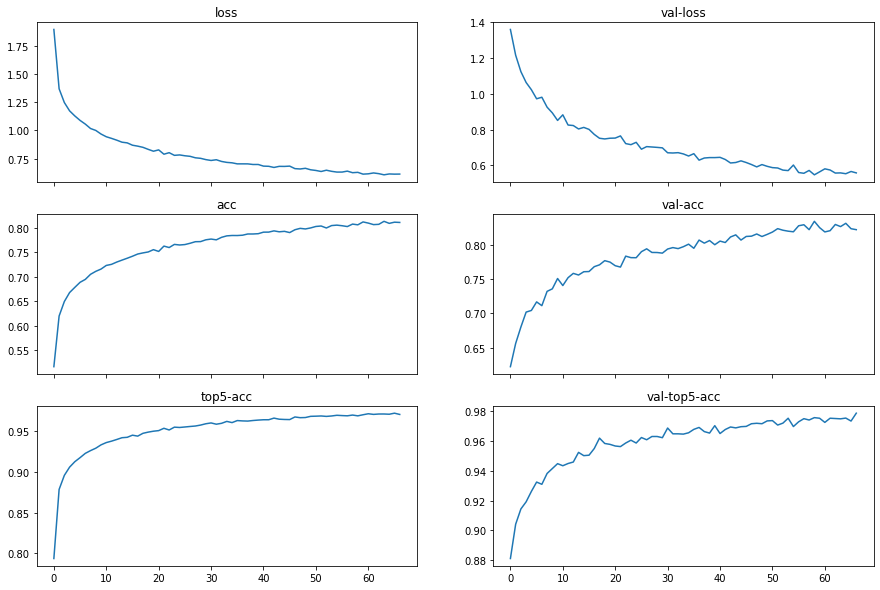

In [26]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharex='col') # add parameter `sharey='row'` for a more direct comparison
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")
ax[2, 0].set_title("top5-acc")
ax[2, 1].set_title("val-top5-acc")

ax[0, 0].plot(history_inception.history['loss'])
ax[0, 1].plot(history_inception.history['val_loss'])
ax[1, 0].plot(history_inception.history['acc'])
ax[1, 1].plot(history_inception.history['val_acc'])
ax[2, 0].plot(history_inception.history['top5_acc'])
ax[2, 1].plot(history_inception.history['val_top5_acc'])


In [27]:
# Get the best performing scores:
best_val_accuracy = max(history_inception.history['val_acc']) * 100
best_val_top5accuracy = max(history_inception.history['val_top5_acc']) * 100

# Print out the results:
print("Best Validation Accuracy: {:2.2f}%".format(best_val_accuracy))
print("Best Validation Top 5 Accuracy: {:2.2f}%".format(best_val_top5accuracy))

Best Validation Accuracy: 83.38%
Best Validation Top 5 Accuracy: 97.86%


### Observation:

Comparing this to the ResNet models, the validation results can be seen to be slightly lower with ~15% decrease in its validation accuracy and ~2% lower in its top 5 validation accuracy. This should mean that the model can be expected to perform worst at recognising the test images.

## 6 - Plot the Predictions:

These images are taken from the web randomly.

In [14]:
# Import the required libraries:
import glob
import numpy as np
from predictions_utility import *

### 6.1 - Load the images in:

In [30]:
# Locate the folder of images:
testing_filenames = glob.glob(os.path.join('Testing Images from Web', '*'))

# testing_filenames = glob.glob(os.path.join('res', '*'))

# Load in the images:
testing_imgs = np.asarray( [load_image(file, size = inception_expected_inputShape[:2]) for file in testing_filenames] )

# Checkout the image shape:
print("Testing Images: {}".format(testing_imgs.shape))

Testing Images: (15, 299, 299, 3)


## 6.2 - Plot:

Use the model to predict on the "image per image" or "batch per batch",  and display the results of its predictions.

NOTE: The model was trainied on CIFAR image data where these images are originally 32x32 pixels, then these were scaled up to 224x224 pixels as suggest by ResNet creators for training. This means that the resulting imaages had important artifacts or low quality features.

To test the model on images of the same quality, the testing images will be resized to 32x32 pixel and then followed by another resizing to an expected input size of 224x224 pixels.

predicted class probabilities: (15, 100)


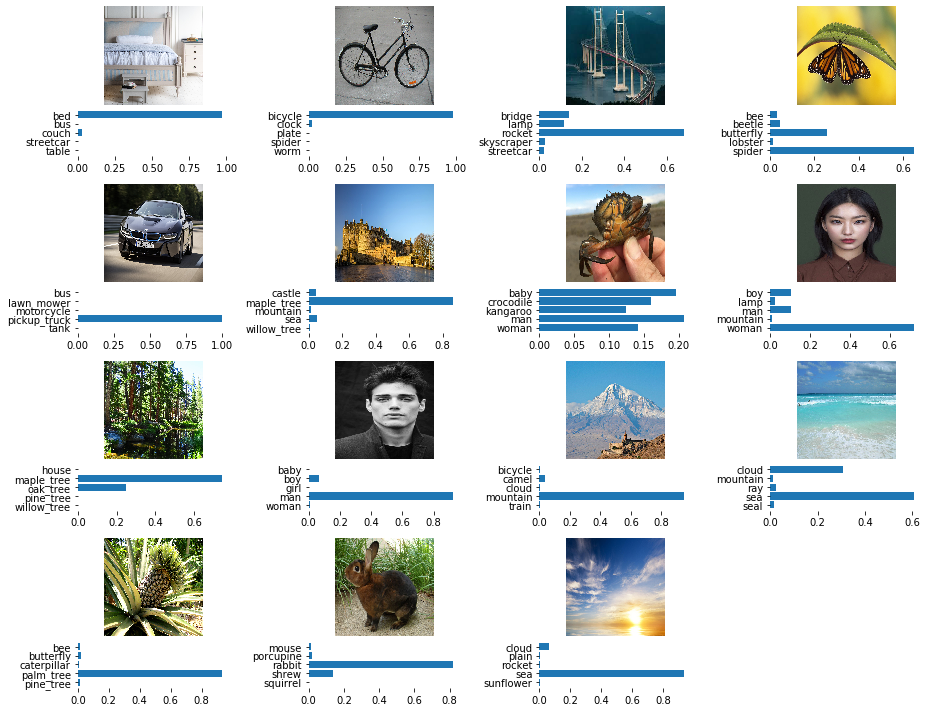

In [33]:
# Define the batch of images:
img_batch = testing_imgs[:16]

# Perform the testing image resize:
cifar_original_imgSize = cifarData_info.features['image'].shape[:2]

# sized to 32x32 pixels.
image_batch_lowQuality = tf.image.resize(images = img_batch,
                                         size = cifar_original_imgSize)
# sized to 224x224 pixels.
image_batch_lowQuality = tf.image.resize(images = image_batch_lowQuality,
                                         size = inception_expected_inputShape[:2])

# Predictions:
predictions = inception_model.predict_on_batch(image_batch_lowQuality)
print("predicted class probabilities: {}".format(predictions.shape))

# Plot: using the utility funcs.
class_readable_labels = cifarData_info.features['label'].names
top5_labels, top5_probs = process_predictions(predictions, class_readable_labels)

display_predicitons(images = img_batch,
                    topk_labels = top5_labels,
                    topk_probabilities = top5_probs)


### Conclusion:

Interestingly, the Inception model is able to differentiate the first and second image here (bed, bicycle etc.) whereas the ResNet model would confuse these two images. The model was able to correctly guess 7/15 images. When considering the top 5 guesses, the model was able to correctly guess 11/15 images. These results means that the Inception network is able to differentiate more images apart and correctly class them within the top 5 guess compared to the more powerful ResNet network.

## 6.3 - Load the images in: from 2nd test folder

In [34]:
# Locate the folder of images:
testing_filenames = glob.glob(os.path.join('Testing Images from Web 2', '*'))

# testing_filenames = glob.glob(os.path.join('res', '*'))

# Load in the images:
testing_imgs = np.asarray( [load_image(file, size = inception_expected_inputShape[:2]) for file in testing_filenames] )

# Checkout the image shape:
print("Testing Images: {}".format(testing_imgs.shape))

Testing Images: (16, 299, 299, 3)


## 6.4 - Plot:

predicted class probabilities: (16, 100)


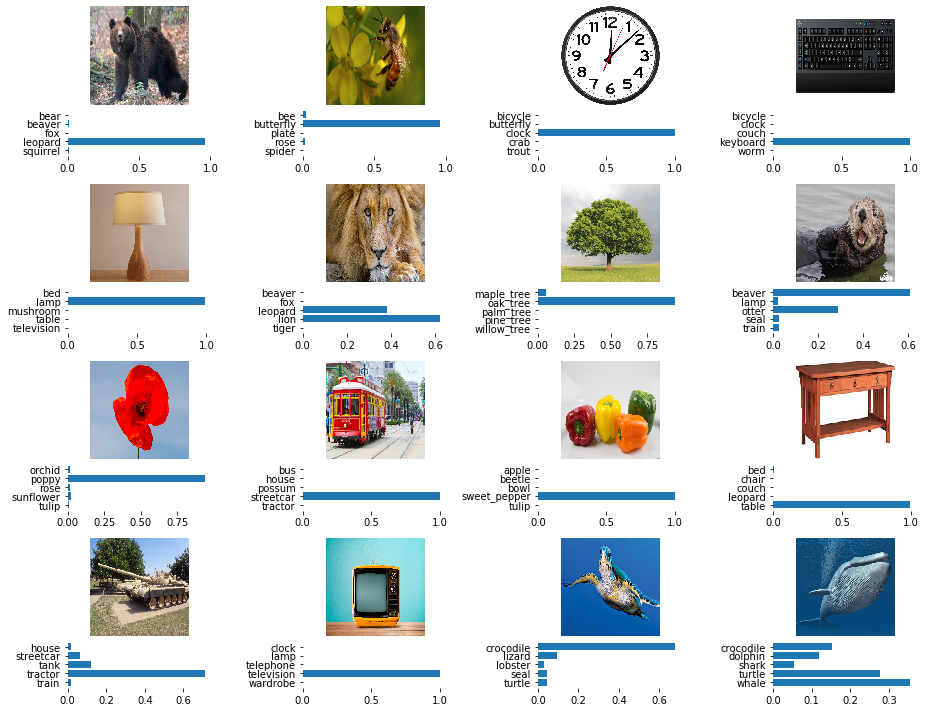

In [35]:
# Define the batch of images:
img_batch = testing_imgs[:16]

# Perform the testing image resize:
cifar_original_imgSize = cifarData_info.features['image'].shape[:2]

# sized to 32x32 pixels.
image_batch_lowQuality = tf.image.resize(images = img_batch,
                                         size = cifar_original_imgSize)
# sized to 224x224 pixels.
image_batch_lowQuality = tf.image.resize(images = image_batch_lowQuality,
                                         size = inception_expected_inputShape[:2])

# Predictions:
predictions = inception_model.predict_on_batch(image_batch_lowQuality)
print("predicted class probabilities: {}".format(predictions.shape))

# Plot: using the utility funcs.
class_readable_labels = cifarData_info.features['label'].names
top5_labels, top5_probs = process_predictions(predictions, class_readable_labels)

display_predicitons(images = img_batch,
                    topk_labels = top5_labels,
                    topk_probabilities = top5_probs)


## Conclusions:

Here, the model correctly guess 11/16 with a high degree of certainty while considering the top 5 guesses, the model was able to correctly guess 16/16 images. Impressiviely, as mentioned earlier, this model does perform better than the ResNet model, which could mean that the ResNet model requires further tuninig. 

## 7 - Testing Out Other Models from TensorFlow Hub: MobileNet

MobileNet V2 belongs to a family of network architectures that is built for mobile and embedded devices. Its architecture allows for an efficient approach to image classification and other tasks for these devices. It uses depthwise separable convolutions that reduces the number of parameters significantly as comparedwith the typical convolutions, resulting in a light weight network model. The model also sacrifices some accuracy as a trade off for latency (from lower compute complextity) which can run more efficiently on devices such as mobile phones and so on.

Source: https://arxiv.org/pdf/1704.04861.pdf

## 7.1 - Define the Hyperparameters:


In [48]:
mobilenet_expected_input_shape = [224, 224, 3]
# mobilenet_expected_output_shape = [2048]
mobilenet_expected_output_shape = [1280]

## 7.2 - Load in the dataset:

In [49]:
# Training Dataset:
train_set_cifar = DataPrepCIFAR_utility.get_dataset(phase='train',
                                                    batch_size= batch_size,
                                                    nb_epochs= nb_epochs,
                                                    shuffle=True,
                                                    input_shape= mobilenet_expected_input_shape,
                                                    seed= Seed_nb)

# Validation Dataset:
val_set_cifar = DataPrepCIFAR_utility.get_dataset(phase='test',
                                                  batch_size= batch_size,
                                                  nb_epochs= 1,
                                                  shuffle= False,
                                                  input_shape= mobilenet_expected_input_shape,
                                                  seed= Seed_nb)

## 7.3 - Fetch MobileNet from Tensorfor Hub:

In [50]:
# TF2.0 Compatible Inception Model:
module_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

In [51]:
hub_feature_extractor = hub.KerasLayer(handle = module_url,
                                       trainable = False,
                                       input_shape = mobilenet_expected_input_shape,
                                       output_shape = mobilenet_expected_output_shape,
                                       dtype = tf.float32)

print(hub_feature_extractor)

In [52]:
# With Keras Sequential API, add the final layers:
mobinenet_model = Sequential(
    [hub_feature_extractor,
     Dense(units = nb_classes,
           activation= 'softmax',
           name = 'logits_pred')],
    name = 'mobilenet_TFHUB'
)

In [53]:
# Model Summary:
mobinenet_model.summary()

Model: "mobilenet_TFHUB"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
logits_pred (Dense)          (None, 100)               128100    
Total params: 2,386,084
Trainable params: 128,100
Non-trainable params: 2,257,984
_________________________________________________________________


## 7.4 - Preparation for Training:

In [54]:
# Define the model optimiser:
optimiser = tf.keras.optimizers.Adam()

# Define the accuracy metric:
accuracy_metric = tf.metrics.SparseCategoricalAccuracy(name = 'acc')

# Define the top-5 accuracy metric: a.k.a Top-K
top5_acc_metric = tf.metrics.SparseTopKCategoricalAccuracy(k = 5,
                                                           name = 'top5_acc')

In [55]:
# Callback to log metrics at the end of each epoch: this saves space compared to Verbose = 1.
metrics_to_print = collections.OrderedDict( [("loss", "loss"), 
                                            ("v-loss", "val_loss"),
                                            ("acc", "acc"), 
                                            ("v-acc", "val_acc"),
                                            ("top5-acc", "top5_acc"), 
                                            ("v-top5-acc", "val_top5_acc")] 
                                          )

In [56]:
# Define the model directtory:
# model_dir = './models/ResNet50_run1'
# model_dir = '.\models\ResNet50_run1'
model_dir = '.\models\mobilenet_TFHUB_run1'

# Define the Callbacks:
callbacks = [
    
    # Callback to interrupt the training if the validation loss/metric stops imrpoving for some amount of epochs:
    tf.keras.callbacks.EarlyStopping(monitor ='val_acc',
                                    patience =8,
                                    restore_best_weights = True
                                    ),
    
    # Callback to log the graph, Losses and Metrics into TensorBoard:
    tf.keras.callbacks.TensorBoard(log_dir = model_dir,
                                    histogram_freq = 0,
                                    write_graph = True
                                  ),
    
    # Callback to save the model: at every 5 epochs and specifies the poch and val-loss in the filename.
#     tf.keras.callbacks.ModelCheckpoint(
#         os.path.join(model_dir, 'weights-epoch{epoch:02}-loss{val_loss:.2f}.h5'), period = 5
#                                     ), 
    
    # Log the Callbacks:
    Simplified_LogCallback(metrics_dict = metrics_to_print,
                           nb_epochs = nb_epochs,
                           log_frequency= 2
                          )  
]



## 7.5 - Compile the model:

In [57]:
mobinenet_model.compile(optimizer = optimiser,
                 loss = 'sparse_categorical_crossentropy',
                 metrics = [accuracy_metric, top5_acc_metric]
                )

## 7.6 - Run the training process for the model:

In [58]:
# running time calculation
start = timeit.default_timer()

In [59]:
history_mobilenet = mobinenet_model.fit(train_set_cifar,
                                          epochs = nb_epochs,
                                          steps_per_epoch= train_steps_per_epoch,
                                          validation_data= (val_set_cifar),
                                          validation_steps= valid_steps_per_epoch,
                                          verbose=0,
                                          callbacks= callbacks)

Training: start
Epoch  1/300: loss = 1.626; v-loss = 1.408; acc = 0.555; v-acc = 0.616; top5-acc = 0.839; v-top5-acc = 0.870
Epoch  3/300: loss = 1.437; v-loss = 1.288; acc = 0.602; v-acc = 0.638; top5-acc = 0.867; v-top5-acc = 0.887
Epoch  5/300: loss = 1.337; v-loss = 1.235; acc = 0.626; v-acc = 0.650; top5-acc = 0.880; v-top5-acc = 0.898
Epoch  7/300: loss = 1.275; v-loss = 1.138; acc = 0.643; v-acc = 0.673; top5-acc = 0.890; v-top5-acc = 0.911
Epoch  9/300: loss = 1.228; v-loss = 1.125; acc = 0.652; v-acc = 0.678; top5-acc = 0.897; v-top5-acc = 0.911
Epoch 11/300: loss = 1.195; v-loss = 1.093; acc = 0.658; v-acc = 0.689; top5-acc = 0.902; v-top5-acc = 0.912
Epoch 13/300: loss = 1.169; v-loss = 1.058; acc = 0.666; v-acc = 0.696; top5-acc = 0.906; v-top5-acc = 0.915
Epoch 15/300: loss = 1.130; v-loss = 1.033; acc = 0.676; v-acc = 0.700; top5-acc = 0.909; v-top5-acc = 0.920
Epoch 17/300: loss = 1.110; v-loss = 1.007; acc = 0.677; v-acc = 0.712; top5-acc = 0.913; v-top5-acc = 0.925
Epo

In [60]:
# Stop the timer:
stop = timeit.default_timer()
print('Time: {} Minutes'.format(round((stop - start)/60, 2)))
print('Time: {} hours'.format(round((stop - start)/3600, 2)))

Time: 25.77 Minutes
Time: 0.43 hours


### Observation:

As it can be seen from the printed logs above, the model was able to achieve an accuracy score of ~97% coupled with a validation accuracy of ~97%. Further, it was able to obtain a validation top-5 accuracy of ~99%. From the process of training, it can be seen that the model took about ~5 hours to reach this point on a decent machine.


## 8 - Model Performance:

## 8.1 - Inspect the TensorBoard:

These can also be found in TensorBoard with the input in terminal: "tensorboard --logdir ./models" or in this case, "tensorboard --logdir .\models\InceptionV3_TFHUB_run1"

![Tensorboard screenshot - joint results](./Description\ Images/Inception_TFHUB_tensorboard_training.png)

## 8.2 - Plot the Model's Performance:

NOTE: the "history" object returned from the "model.fit()" method also provides data for plotting the training metrics. The following till plot these metrics.

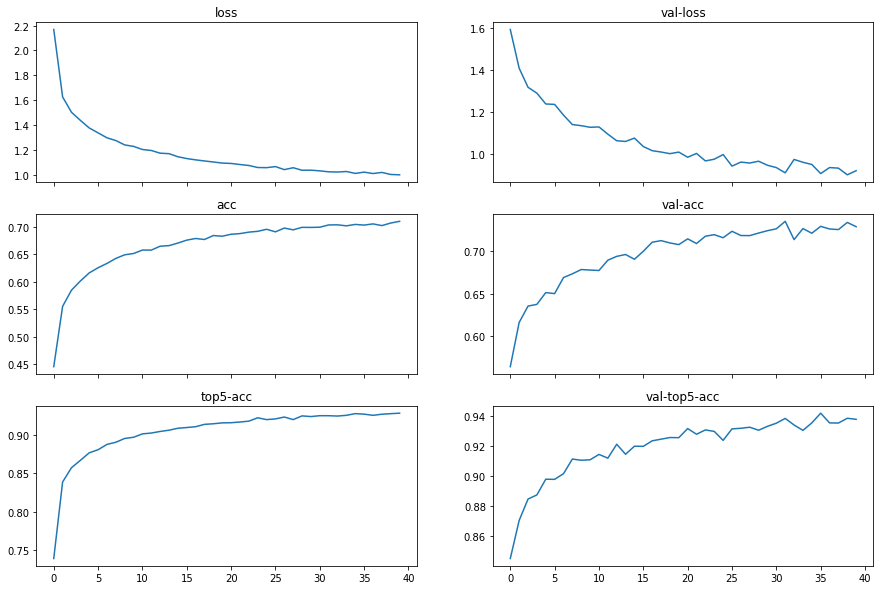

In [61]:
fig, ax = plt.subplots(3, 2, figsize=(15, 10), sharex='col') # add parameter `sharey='row'` for a more direct comparison
ax[0, 0].set_title("loss")
ax[0, 1].set_title("val-loss")
ax[1, 0].set_title("acc")
ax[1, 1].set_title("val-acc")
ax[2, 0].set_title("top5-acc")
ax[2, 1].set_title("val-top5-acc")

ax[0, 0].plot(history_mobilenet.history['loss'])
ax[0, 1].plot(history_mobilenet.history['val_loss'])
ax[1, 0].plot(history_mobilenet.history['acc'])
ax[1, 1].plot(history_mobilenet.history['val_acc'])
ax[2, 0].plot(history_mobilenet.history['top5_acc'])
ax[2, 1].plot(history_mobilenet.history['val_top5_acc'])


In [72]:
# Get the best performing scores:
best_val_accuracy = max(history_mobilenet.history['val_acc']) * 100
best_val_top5accuracy = max(history_mobilenet.history['val_top5_acc']) * 100

# Print out the results:
print("Best Validation Accuracy: {:2.2f}%".format(best_val_accuracy))
print("Best Validation Top 5 Accuracy: {:2.2f}%".format(best_val_top5accuracy))

Best Validation Accuracy: 73.47%
Best Validation Top 5 Accuracy: 94.19%


### Observation:

Comparing this to the ResNet and Inception models, the validation results can be seen to be slightly lower with ~20% decrease in its validation accuracy and ~5% lower in its top 5 validation accuracy. This should mean that the model can be expected to perform worst at recognising the test images which make sense as the creators sacrificed accuracy for latency.

## 9 - Plot the Predictions:

These images are taken from the web randomly.

In [67]:
# Import the required libraries:
import glob
import numpy as np
from predictions_utility import *

### 9.1 - Load the images in:

In [68]:
# Locate the folder of images:
testing_filenames = glob.glob(os.path.join('Testing Images from Web', '*'))

# testing_filenames = glob.glob(os.path.join('res', '*'))

# Load in the images:
testing_imgs = np.asarray( [load_image(file, size = inception_expected_inputShape[:2]) for file in testing_filenames] )

# Checkout the image shape:
print("Testing Images: {}".format(testing_imgs.shape))

Testing Images: (15, 299, 299, 3)


## 9.2 - Plot:

Use the model to predict on the "image per image" or "batch per batch",  and display the results of its predictions.

NOTE: The model was trainied on CIFAR image data where these images are originally 32x32 pixels, then these were scaled up to 224x224 pixels. This means that the resulting imaages had important artifacts or low quality features.

To test the model on images of the same quality, the testing images will be resized to 32x32 pixel and then followed by another resizing to an expected input size of 224x224 pixels.

cifar original img size is: (32, 32)
predicted class probabilities: (15, 100)


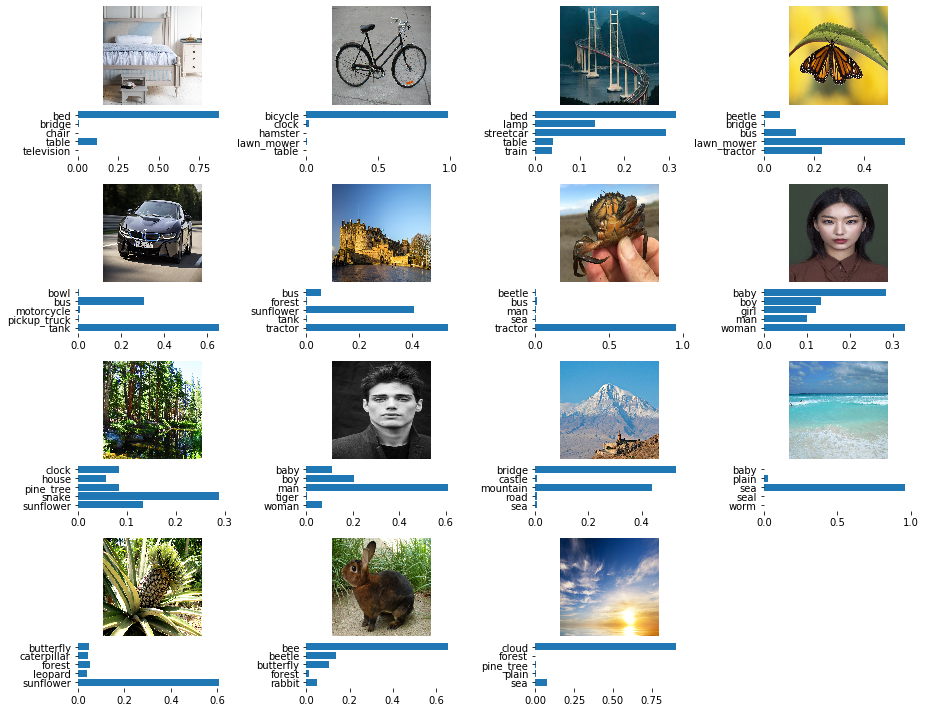

In [69]:
# Define the batch of images:
img_batch = testing_imgs[:16]

# Perform the testing image resize:
cifar_original_imgSize = cifarData_info.features['image'].shape[:2]
print('cifar original img size is: {}'.format(cifar_original_imgSize))

# sized to 32x32 pixels.
image_batch_lowQuality = tf.image.resize(images = img_batch,
                                         size = cifar_original_imgSize)
# sized to 224x224 pixels.
image_batch_lowQuality = tf.image.resize(images = image_batch_lowQuality,
                                         size = mobilenet_expected_input_shape[:2])

# Predictions:
predictions = mobinenet_model.predict_on_batch(image_batch_lowQuality)
print("predicted class probabilities: {}".format(predictions.shape))

# Plot: using the utility funcs.
class_readable_labels = cifarData_info.features['label'].names
top5_labels, top5_probs = process_predictions(predictions, class_readable_labels)

display_predicitons(images = img_batch,
                    topk_labels = top5_labels,
                    topk_probabilities = top5_probs)


### Conclusion:

The MobileNet model is able to differentiate the first and second image here (bed, bicycle etc.), similar to Inception model, whereas the ResNet model would confuse these two images. The model was able to correctly guess 6/15 images. When considering the top 5 guesses, the model was able to correctly guess 8/15 images. As mentioned, this model sacrifices some accuray for the improvement in latency for mobile devices, so the top 5 guess are not that much better when compared to the other two models.

## 9.3 - Load the images in: from 2nd test folder

In [70]:
# Locate the folder of images:
testing_filenames = glob.glob(os.path.join('Testing Images from Web 2', '*'))

# testing_filenames = glob.glob(os.path.join('res', '*'))

# Load in the images:
testing_imgs = np.asarray( [load_image(file, size = mobilenet_expected_input_shape[:2]) for file in testing_filenames] )

# Checkout the image shape:
print("Testing Images: {}".format(testing_imgs.shape))

Testing Images: (16, 224, 224, 3)


## 9.4 - Plot:

predicted class probabilities: (16, 100)


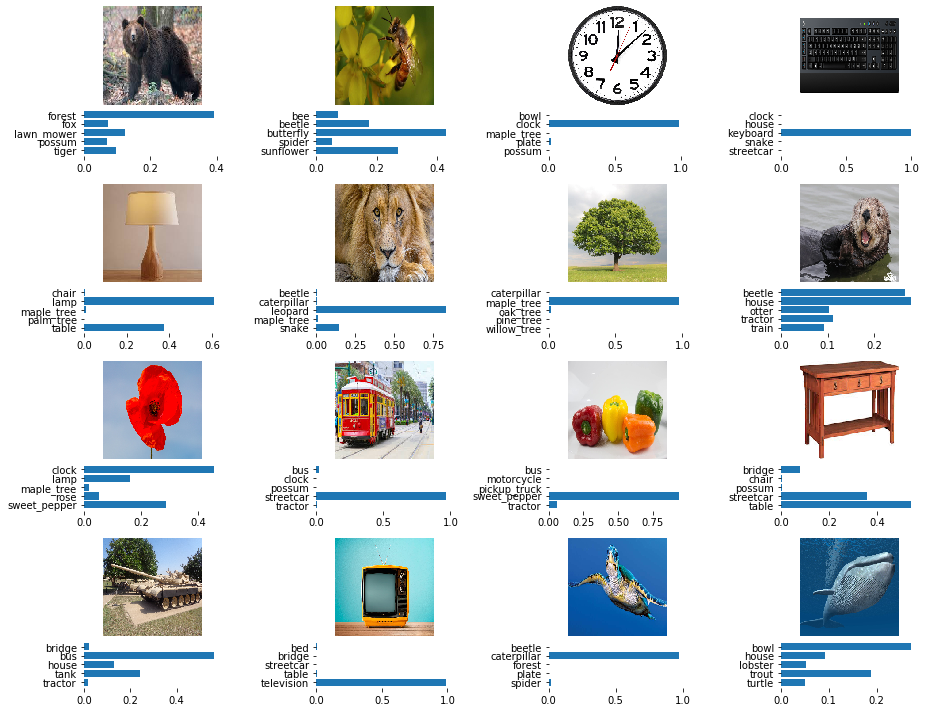

In [71]:
# Define the batch of images:
img_batch = testing_imgs[:16]

# Perform the testing image resize:
cifar_original_imgSize = cifarData_info.features['image'].shape[:2]

# sized to 32x32 pixels.
image_batch_lowQuality = tf.image.resize(images = img_batch,
                                         size = cifar_original_imgSize)
# sized to 224x224 pixels.
image_batch_lowQuality = tf.image.resize(images = image_batch_lowQuality,
                                         size = mobilenet_expected_input_shape[:2])

# Predictions:
predictions = mobinenet_model.predict_on_batch(image_batch_lowQuality)
print("predicted class probabilities: {}".format(predictions.shape))

# Plot: using the utility funcs.
class_readable_labels = cifarData_info.features['label'].names
top5_labels, top5_probs = process_predictions(predictions, class_readable_labels)

display_predicitons(images = img_batch,
                    topk_labels = top5_labels,
                    topk_probabilities = top5_probs)


## Conclusions:

Here, the model correctly guess 8/16 with a high degree of certainty while considering the top 5 guesses, the model was able to correctly guess 11/16 images. So this is not that much better than the ResNet model, which is very impressive considering its lighter architecture.

## Summary:

Although this is not the end of this project, it does conclude the 1st notebook relevant to the theory of these advanced deep learning models. Please go to check out __Notebook 6__ for the __Transfer Learning and Applying It__.